# Pipeline
## Cleaning confounds
We first created the confound matrix according to Smith et al. (2015). The confound variables are motion (Jenkinson), sex, and age. We also created squared confound measures to help account for potentially nonlinear effects of these confounds.
## Nested k-fold cross validation
We employed the nested approach to accomandate the hyper-parameter selection and model selection. This is a complex and costly method but the smaple size allows us to use this approach.

In [1]:
import copy
import os, sys
import numpy as np
import pandas as pd

import joblib

In [2]:
os.chdir('../')

In [3]:
# loa my modules
from src.utils import load_pkl
from src.file_io import save_output
from src.models import nested_kfold_cv_scca, clean_confound, permutate_scca
from src.visualise import set_text_size, show_results, write_pdf, write_png

In [4]:
dat_path = './data/processed/dict_SCCA_data_prepro_06092017.pkl'
# load data
dataset = load_pkl(dat_path)

FC_yeo7 = dataset['FC_Yeo7']
MRIQ    = dataset['MRIQ']
mot     = dataset['Motion_Jenkinson']
sex     = dataset['Gender']
age     = dataset['Age']
confound_raw = np.hstack((mot, sex, age))

In [5]:
out_folds = 5
in_folds = 5
n_selected = 4

## confound cleaning before model selection

Fold 1/5


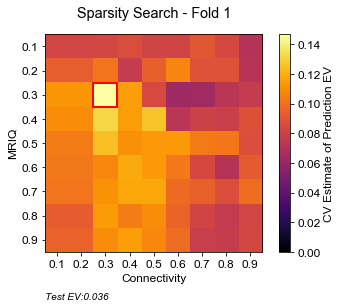


New Best model: 
 4 components,penalty x: 0.3, penalty y: 0.3
OOS performance: 0.0360578501684
Fold 2/5


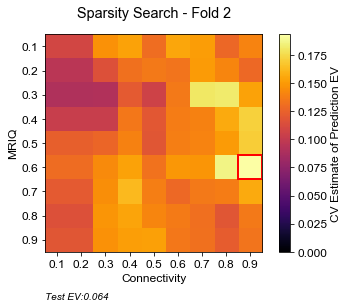


New Best model: 
 4 components,penalty x: 0.9, penalty y: 0.6
OOS performance: 0.0641719709423
Fold 3/5


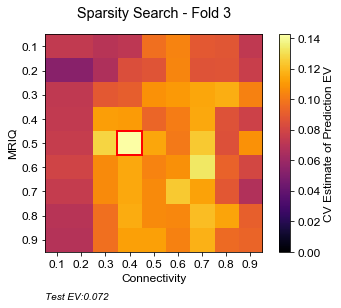


New Best model: 
 4 components,penalty x: 0.4, penalty y: 0.5
OOS performance: 0.0718691292266
Fold 4/5


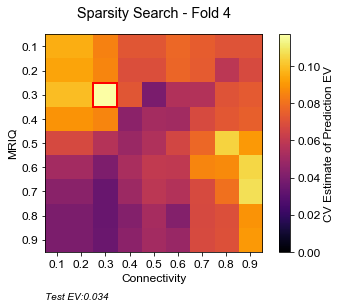

Fold 5/5


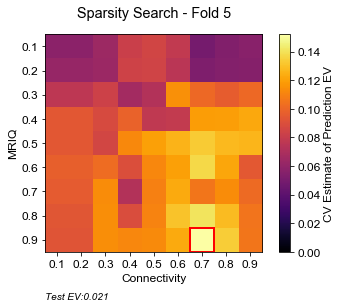


Best parameters based on outer fold ev results: X-0.4; Y-0.5

CPU times: user 2min 6s, sys: 2.22 s, total: 2min 8s
Wall time: 2min 6s


In [6]:
%%time
X, Y, R = clean_confound(FC_yeo7, MRIQ, confound_raw)
para_search, best_model, pred_errors = nested_kfold_cv_scca(
    X, Y, R=None, n_selected=n_selected, 
    out_folds=5, in_folds=5, 
    reg_X=(0.1, 0.9), reg_Y=(0.1, 0.9)
)

## confound cleaning in CV loops

Fold 1/5


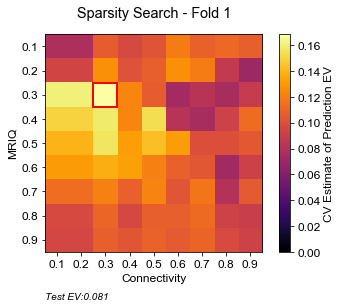


New Best model: 
 4 components,penalty x: 0.3, penalty y: 0.3
OOS performance: 0.0814054950884
Fold 2/5


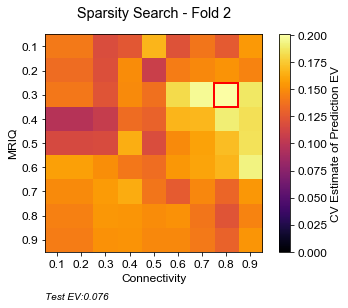

Fold 3/5


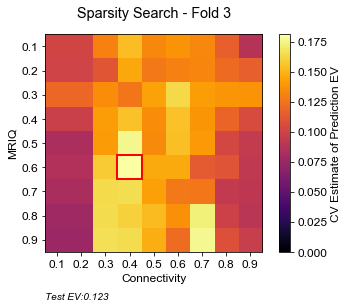


New Best model: 
 4 components,penalty x: 0.4, penalty y: 0.6
OOS performance: 0.12317926164
Fold 4/5


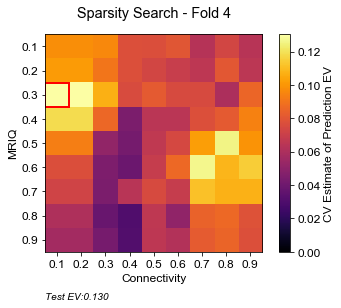


New Best model: 
 4 components,penalty x: 0.1, penalty y: 0.3
OOS performance: 0.130157090656
Fold 5/5


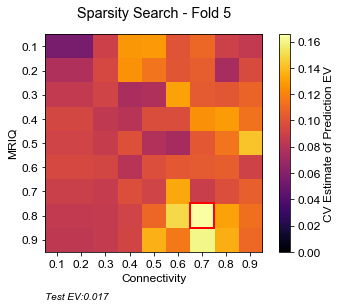


Best parameters based on outer fold ev results: X-0.1; Y-0.3

CPU times: user 4min 7s, sys: 6min 36s, total: 10min 44s
Wall time: 3min 9s


In [7]:
%%time
_para_search, _best_model, _pred_errors = nested_kfold_cv_scca(
    FC_yeo7, MRIQ, R=confound_raw, n_selected=n_selected, 
    out_folds=5, in_folds=5, 
    reg_X=(0.1, 0.9), reg_Y=(0.1, 0.9)
)

In [8]:
u, v = best_model.u, best_model.v

set_text_size(12)
figs = show_results(u, v, dataset['Yeo7_ROIs'], dataset['MRIQ_labels'], rank_v=True, sparse=True)
write_png('./reports/revision/bestModel_r2z_component_{:}.png', figs)

X_scores, Y_scores, df_z = save_output(dataset, confound_raw, best_model, X, Y, path=None)

df_z.to_csv('./data/processed/NYCQ_CCA_score_revision_r2z_{0:1d}_{1:.1f}_{2:.1f}.csv'.format(
            best_model.n_components, best_model.penX, best_model.penY))
df_z.to_pickle('./data/processed/NYCQ_CCA_score_revision_r2z_{0:1d}_{1:.1f}_{2:.1f}.pkl'.format(
            best_model.n_components, best_model.penX, best_model.penY))

joblib.dump(best_model, 
            './models/SCCA_Yeo7_revision_r2z_{:1d}_{:.2f}_{:.2f}.pkl'.format(
                best_model.n_components, best_model.penX, best_model.penY))

['./models/SCCA_Yeo7_revision_r2z_4_0.40_0.50.pkl']

In [ ]:
df_permute = permutate_scca(X, Y, best_model.cancorr_, best_model, n_permute=1000)
df_permute

In [ ]:
set_text_size(12)
figs = show_results(_best_model.u, _best_model.v, dataset['Yeo7_ROIs'], dataset['MRIQ_labels'], rank_v=True, sparse=True)
write_png('./reports/revision/bestModel_extensiveclean_component_{:}.png', figs)

X_scores, Y_scores, df_z = save_output(dataset, confound_raw, _best_model, X, Y, path=None)
df_z.to_csv('./data/processed/NYCQ_CCA_score_extensiveclean_{0:1d}_{1:.1f}_{2:.1f}.csv'.format(
            _best_model.n_components, _best_model.penX, _best_model.penY))
df_z.to_pickle('./data/processed/NYCQ_CCA_score_extensiveclean_{0:1d}_{1:.1f}_{2:.1f}.pkl'.format(
            _best_model.n_components, _best_model.penX, _best_model.penY))

joblib.dump(_best_model, 
            './models/SCCA_Yeo7_revision_extensiveclean_{:1d}_{:.2f}_{:.2f}.pkl'.format(
                _best_model.n_components, _best_model.penX, _best_model.penY))